In [3]:
import sys
import os
import struct
import time
import numpy as np
import gc
import h5py
from scipy.io import loadmat
from scipy.stats import pearsonr
from tqdm import tqdm
import pickle
import math
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
%matplotlib inline

fpX = np.float32

import torch 
sys.path.append('/user_data/mmhender/llorg/fwrf_code_from_osf/')
import src.numpy_utility as pnu
from src.file_utility import save_stuff, flatten_dict, embed_dict
from src.gabor_feature_extractor import Gaborizer
from src.torch_fwrf import learn_params_ridge_regression, get_predictions, get_value, set_value, Torch_fwRF_voxel_block, get_r2, add_nonlinearity, get_features_in_prf, get_fmaps_sizes
from src.rf_grid import linspace, logspace
import src.numpy_utility as pnu
from src.file_utility import save_stuff, flatten_dict, embed_dict
from src.load_nsd import image_uncolorize_fn


In [4]:
import torch
device = torch.device('cpu:0')
# print ('#device:', torch.cuda.device_count())
# print ('device#:', torch.cuda.current_device())
# print ('device name:', torch.cuda.get_device_name(torch.cuda.current_device()))

# torch.manual_seed(time.time())
# device = torch.device("cuda:0") #cuda
# torch.backends.cudnn.enabled=True

# print ('\ntorch:', torch.__version__)
# print ('cuda: ', torch.version.cuda)
# print ('cudnn:', torch.backends.cudnn.version())
# print ('dtype:', torch.get_default_dtype())
# #torch.set_default_dtype(torch.float64)

In [5]:
nsd_root = "/lab_data/tarrlab/common/datasets/NSD/"
stim_root = '/user_data/mmhender/nsd_stimuli/stimuli/nsd/'
mask_root = nsd_root + "nsddata/ppdata/"
subject = 1
saveext = ".png"
savearg = {'format':'png', 'dpi': 120, 'facecolor': None}
root_dir   = os.path.dirname(os.getcwd())
net_dir    = root_dir + "net/" 
model_name = 'gabor_fwrf'

In [6]:
# timestamp = 'May-07-2021_2028'
timestamp='May-09-2021_2223'
output_dir = os.path.join(root_dir, 'gabor_model_fits','S%02d'%subject,'%s_%s/'% (model_name,timestamp) )

fns = os.listdir(output_dir)
print(fns)
out = torch.load(os.path.join(output_dir, fns[0]))
print(out.keys())

sf_tuning_masks = out['sf_tuning_masks']
ori_tuning_masks = out['ori_tuning_masks']
orient_filters = out['orient_filters']

['model_params_allROIs']
dict_keys(['feature_table', 'sf_tuning_masks', 'ori_tuning_masks', 'cyc_per_stim', 'orients_deg', 'orient_filters', 'aperture', 'voxel_mask', 'brain_nii_shape', 'image_order', 'voxel_index', 'voxel_roi', 'voxel_ncsnr', 'best_params', 'lambdas', 'best_lambdas', 'best_losses', 'val_cc', 'val_r2', 'partition_cc_sf', 'partition_r2_sf', 'partition_cc_orient', 'partition_r2_orient', 'features_each_model_val', 'covar_each_model_val', 'covar_each_model_training'])


In [7]:
## Loading saved fit parameters...

timestamp = 'May-04-2021_0340'
# timestamp='May-09-2021_2223'
output_dir = os.path.join(root_dir, 'gabor_model_fits','S%02d'%subject,'%s_%s/'% (model_name,timestamp) )

fns = os.listdir(output_dir)
print(fns)
out = torch.load(os.path.join(output_dir, fns[0]))
print(out.keys())

aperture = out['aperture']
cyc_per_stim  = out['cyc_per_stim']
orients_deg = out['orients_deg']

voxel_mask = out['voxel_mask']
brain_nii_shape = out['brain_nii_shape']
image_order = out['image_order']
voxel_idx = out['voxel_index']
voxel_roi = out['voxel_roi']

val_cc = out['val_cc']
best_params = out['best_params']
best_lambdas = out['best_lambdas']
best_losses = out['best_losses']
lambdas = out['lambdas']

# Best params[0] = x,y,sigma for pRF estimates [n_voxels x 3]
print(np.shape(best_params[0]))
# Best params[1] = best weights [n_voxels x nFeatures]
print(np.shape(best_params[1]))

best_models = best_params[0]
best_ecc  = np.sqrt(np.square(best_models[:,0]) + np.square(best_models[:,1]))
best_ang  = np.arctan2(best_models[:,1], best_models[:,0])
best_size = best_models[:,2]

feature_weights = best_params[1]

n_sf = len(cyc_per_stim)
n_ori = len(orients_deg)
n_voxels = np.shape(feature_weights)[0]
n_features_total = np.shape(feature_weights)[1]


['model_params_allROIs', 'val_cc.nii', 'rf_ecc.nii', 'rf_ang.nii', 'rf_size.nii']
dict_keys(['lmask', 'fmask', 'tuning_masks', 'ori_tuning_masks', 'cyc_per_stim', 'orients_deg', 'aperture', 'voxel_mask', 'brain_nii_shape', 'image_order', 'voxel_index', 'voxel_roi', 'best_params', 'lambdas', 'best_lambdas', 'val_cc', 'best_losses', 'partition_val_sf', 'partition_val_orient'])
(11694, 3)
(11694, 432)


In [8]:
features_each_model_val = out['features_each_model_val']
np.shape(features_each_model_val)
covar_each_model_val = out['covar_each_model_val']
np.shape(covar_each_model_val)
# covar_each_model_training = out['covar_each_model_training']
# np.shape(covar_each_model_training)

KeyError: 'features_each_model_val'

In [9]:
from src.rf_grid    import linspace, logspace, model_space, model_space_pyramid
aperture = np.float32(1)
smin, smax = np.float32(0.04), np.float32(0.4)
n_sizes = 8

# models is three columns, x, y, sigma
models = model_space_pyramid(logspace(n_sizes)(smin, smax), min_spacing=1.4, aperture=1.1*aperture)    
models.shape[0]

875

In [10]:
# From the saved fit parameters, select an example voxel that was well fit...
# vidx = np.argsort(val_cc)[-1]

# find a voxel with tuning close to the center of the visual field
near_center = np.where(best_ecc==0)[0]
vidx = near_center[np.argmax(val_cc[near_center])]

x,y,sigma = best_models[vidx,:]
# x=0;y=0;

best_lambda_ind = best_lambdas[vidx]

print(vidx, val_cc[vidx])
print(x,y,sigma)
print(best_lambda_ind)
print(lambdas[best_lambda_ind])
print(best_losses[vidx])
print(feature_weights[vidx,0:10])

8642 0.39194053
0.0 0.0 0.2878742814064026
3
74.98942
1158.105
[-0.01801145 -0.0133084   0.00520684  0.04061244  0.01651131 -0.05755285
 -0.00415077  0.05185637  0.03086233 -0.02971462]


In [11]:
# Load some of the actual voxel data, to use for testing stuff

beta_root = nsd_root + "nsddata_betas/ppdata/"
mask_root = nsd_root + "nsddata/ppdata/"
exp_design_file = nsd_root + "nsddata/experiments/nsd/nsd_expdesign.mat"

beta_subj = beta_root + "subj%02d/func1pt8mm/betas_fithrf_GLMdenoise_RR/" % (subject,)

from src.load_nsd import load_betas
full_voxel_data, filenames = load_betas(folder_name=beta_subj, zscore=True, voxel_mask=voxel_mask, up_to=1, load_ext=".nii")
print (full_voxel_data.shape)

# Loading images to do some more testing...

exp_design = loadmat(exp_design_file)
ordering = exp_design['masterordering'].flatten() - 1 # zero-indexed ordering of indices (matlab-like to python-like)

image_data = {}
image_data_set = h5py.File(stim_root + "S%d_stimuli_227.h5py"%subject, 'r')
image_data = np.copy(image_data_set['stimuli'])
image_data_set.close()
print ('block size:', image_data.shape, ', dtype:', image_data.dtype, ', value range:',\
    np.min(image_data[0]), np.max(image_data[0]))

from src.load_nsd import image_uncolorize_fn, data_split

# Setting up training/testing splits...

# n_trials, n_voxels = full_voxel_data.shape 
trn_stim_data, trn_voxel_data,\
val_stim_single_trial_data, val_voxel_single_trial_data,\
val_stim_multi_trial_data, val_voxel_multi_trial_data = \
    data_split(image_uncolorize_fn(image_data), full_voxel_data, ordering, imagewise=False)

/lab_data/tarrlab/common/datasets/NSD/nsddata_betas/ppdata/subj01/func1pt8mm/betas_fithrf_GLMdenoise_RR/betas_session01.nii.gz
int16 -32768 32767 (750, 81, 104, 83)
<beta> = 1.271, <sigma> = 1.348
(750, 11694)
block size: (10000, 3, 227, 227) , dtype: uint8 , value range: 0 255
Total number of voxels = 11694


In [12]:
np.shape(image_data)

(10000, 3, 227, 227)

In [13]:
np.shape(image_uncolorize_fn(image_data))

(10000, 1, 227, 227)

In [40]:
# Setting up the feature extractor w gabor filter bank

from src.torch_fwrf import get_value, set_value, _to_torch
from src.gabor_feature_extractor import Gaborizer
from src.rf_grid import linspace, logspace

class add_nonlinearity(torch.nn.Module):
    def __init__(self, _fmaps_fn, _nonlinearity):
        super(add_nonlinearity, self).__init__()
        self.fmaps_fn = _fmaps_fn
        self.nl_fn = _nonlinearity
    def forward(self, _x):
        return [self.nl_fn(_fm) for _fm in self.fmaps_fn(_x)]

n_ori = 36
n_sf = 12
# cyc_per_stim = logspace(12)(3., 72.) # 6-92
cyc_per_stim = logspace(n_sf)(3., 72.)
pix_per_cycle = 4.13   # this changes the actual size of filters in pixels, might help with orientation resolution?
# pix_per_cycle = 6

_gaborizer = Gaborizer(num_orientations=n_ori, cycles_per_stim=cyc_per_stim,
          pix_per_cycle=pix_per_cycle, cycles_per_radius=.7, 
          radii_per_filter=4, complex_cell=True, pad_type='half', 
          crop=False).to(device)

# _fmaps_fn = _gaborizer
_fmaps_fn = add_nonlinearity(_gaborizer, lambda x: torch.log(1+torch.sqrt(x)))

# pull out some relevant stuff from gaborizer object to save
sf_tuning_masks = _gaborizer.sf_tuning_masks
assert(np.all(_gaborizer.cyc_per_stim==cyc_per_stim))

ori_tuning_masks = _gaborizer.ori_tuning_masks
orients_deg = _gaborizer.orients_deg
orient_filters = _gaborizer.orient_filters    


In [41]:
# Set up some more parameters for the fitting procedure

vox2use = range(vidx, vidx+1)
models = np.array([x,y,sigma])
models = [models,]

# zscore=True
zscore=False
add_bias=True
shuffle=False

dtype=fpX
sample_batch_size=20
_nonlinearity=None

images = trn_stim_data
voxel_data = trn_voxel_data[:,vox2use]

holdout_pct = 0.10
holdout_size = int(np.ceil(np.shape(trn_voxel_data)[0]*holdout_pct))
trn_size = len(voxel_data) - holdout_size

n_trials = images.shape[0]
n_voxels = voxel_data.shape[1]

order = np.arange(len(voxel_data), dtype=int)
if shuffle:
    np.random.shuffle(order)
images   = images[order]
voxel_data = voxel_data[order]  
trn_data = voxel_data[:trn_size]
out_data = voxel_data[trn_size:]


gc.collect()
torch.cuda.empty_cache()
    

In [ ]:
_x = torch.tensor(images).to(device) # the input variable.
print(_x.get_device())

In [54]:
def get_fmaps_sizes(_fmaps_fn, image_batch, device):
    """ 
    Passing a batch of images through feature maps, in order to compute sizes.
    Returns number of total features across all groups of maps, and the resolution of each map group.
    """
    n_features = 0
    _x = torch.tensor(image_batch).to(device) # the input variable.
    print(_x.get_device())
    _fmaps = _fmaps_fn(_x)
    resolutions_each_sf = []
    for k,_fm in enumerate(_fmaps):
        n_features = n_features + _fm.size()[1]
        resolutions_each_sf.append(_fm.size()[2])
    
    return n_features, resolutions_each_sf

In [55]:
# Get features for the desired pRF, across all trn set image 
n_features, fmaps_rez = get_fmaps_sizes(_fmaps_fn, torch.tensor(images[0:sample_batch_size]).to(device), device)
features = get_features_in_prf((x,y,sigma), _fmaps_fn, images, sample_batch_size, device)

if zscore:  
    features_m = np.mean(features, axis=0, keepdims=True)
    features_s = np.std(features, axis=0, keepdims=True) + 1e-6          
    features -= features_m
    features /= features_s    

if add_bias:
    features = np.concatenate([features, np.ones(shape=(len(features), 1), dtype=dtype)], axis=1)
    
print(features.shape)

-1


/home/mmhender/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys


RuntimeError: Device index must not be negative

In [427]:
# Create full model value buffers    

best_models = np.full(shape=(n_voxels,), fill_value=-1, dtype=int)   
best_lambdas = np.full(shape=(n_voxels,), fill_value=-1, dtype=int)
best_losses = np.full(fill_value=np.inf, shape=(n_voxels), dtype=dtype)
best_w_params = np.zeros(shape=(n_voxels, n_features ), dtype=dtype)

if add_bias:
    best_w_params = np.concatenate([best_w_params, np.ones(shape=(len(best_w_params),1), dtype=dtype)], axis=1)
features_mean = None
features_std = None
if zscore:
    features_mean = np.zeros(shape=(n_voxels, n_features), dtype=dtype)
    features_std  = np.zeros(shape=(n_voxels, n_features), dtype=dtype)


In [428]:
# Doing fitting on training set...

# separate design matrix into training/held out data (for lambda selection)
trn_features = features[:trn_size]
out_features = features[trn_size:]   

# Send matrices to gpu
_xtrn = _to_torch(trn_features, device=device)
_xout = _to_torch(out_features, device=device)   

# Do part of the matrix math involved in ridge regression
_cof = _cofactor_fn(_xtrn, lambdas, device=device)

# Send matrices to gpu
_vtrn = _to_torch(trn_data, device=device)
_vout = _to_torch(out_data, device=device)

# Here is where optimization happens - relatively simple matrix math inside loss fn.
_betas, _loss = _loss_fn(_cof, _vtrn, _xout, _vout) #   [#lambda, #feature, #voxel, ], [#lambda, #voxel]
# Now have a set of weights (in betas) and a loss value for every voxel and every lambda. 
# goal is then to choose for each voxel, what is the best lambda and what weights went with that lambda.

# first choose best lambda value and the loss that went with it.
_values, _select = torch.min(_loss, dim=0)
betas = get_value(_betas)
values, select = get_value(_values), get_value(_select)



In [429]:
# Adding these fit parameters to bigger matrices to use as input to evaluation functions

imp = np.ones(shape=(n_voxels,),dtype=bool)
rv = range(0,1)
m=0

if np.sum(imp)>0:
    # for whichever voxels had improvement relative to previous models, save parameters now
    # this means we won't have to save all params for all models, just best.
    arv = np.array(rv)[imp]
    li = select[imp]
    best_lambdas[arv] = li
    best_losses[arv] = values[imp]
    best_models[arv] = m
    if zscore:
        features_mean[arv] = features_m # broadcast over updated voxels
        features_std[arv]  = features_s
    # taking the weights associated with the best lambda value
    best_w_params[arv,:] = pnu.select_along_axis(betas[:,:,imp], li, run_axis=2, choice_axis=0).T

return_params = [best_w_params[:,:n_features],]
if add_bias:
    return_params += [best_w_params[:,-1],]
else: 
    return_params += [None,]

models= models[m]
models = np.array(models)
models = models[np.newaxis,:]
best_params = [models]+return_params+[features_mean, features_std]

In [430]:
# Evaluating fit on validation set

param_batch = best_params
# To initialize this module for prediction, need to take just first batch of voxels.
# Will eventually pass all voxels through in batches.
_fwrf_fn = Torch_fwRF_voxel_block(_fmaps_fn, param_batch, input_shape=val_stim_single_trial_data.shape, aperture=1.0)

print('\nGetting model predictions on validation set...\n')
val_voxel_pred = get_predictions(val_stim_single_trial_data, _fmaps_fn, _fwrf_fn, best_params, sample_batch_size=sample_batch_size)

# val_cc is the correlation coefficient bw real and predicted responses across trials, for each voxel.
val_cc  = np.zeros(shape=(n_voxels), dtype=fpX)
val_r2 = np.zeros(shape=(n_voxels), dtype=fpX)

print('\nEvaluating correlation coefficient on validation set...\n')

val_cc[0] = np.corrcoef(val_voxel_single_trial_data[:,vidx], val_voxel_pred[:,0])[0,1]  
val_r2[0] = get_r2(val_voxel_single_trial_data[:,vidx], val_voxel_pred[:,0])

print(val_cc[0])
print(val_r2[0])

Making fwrf module...

Getting model predictions on validation set...

samples [ 1480:1490 ] of 1491, voxels [     0:0     ] of 1
---------------------------------------
total time = 6.280006s
sample throughput = 0.004212s/sample
voxel throughput = 6.280006s/voxel

Evaluating correlation coefficient on validation set...

1307.8666
1496.2839
0.36718228
0.12592351


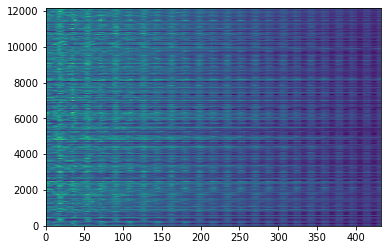

In [432]:
# visualizing ntrials x nfeatures (no z-score)

plt.figure();
trn_features_actual = trn_features[:,0:n_features]
plt.pcolormesh(trn_features_actual)

(0.0, 432.0, 0.0, 432.0)

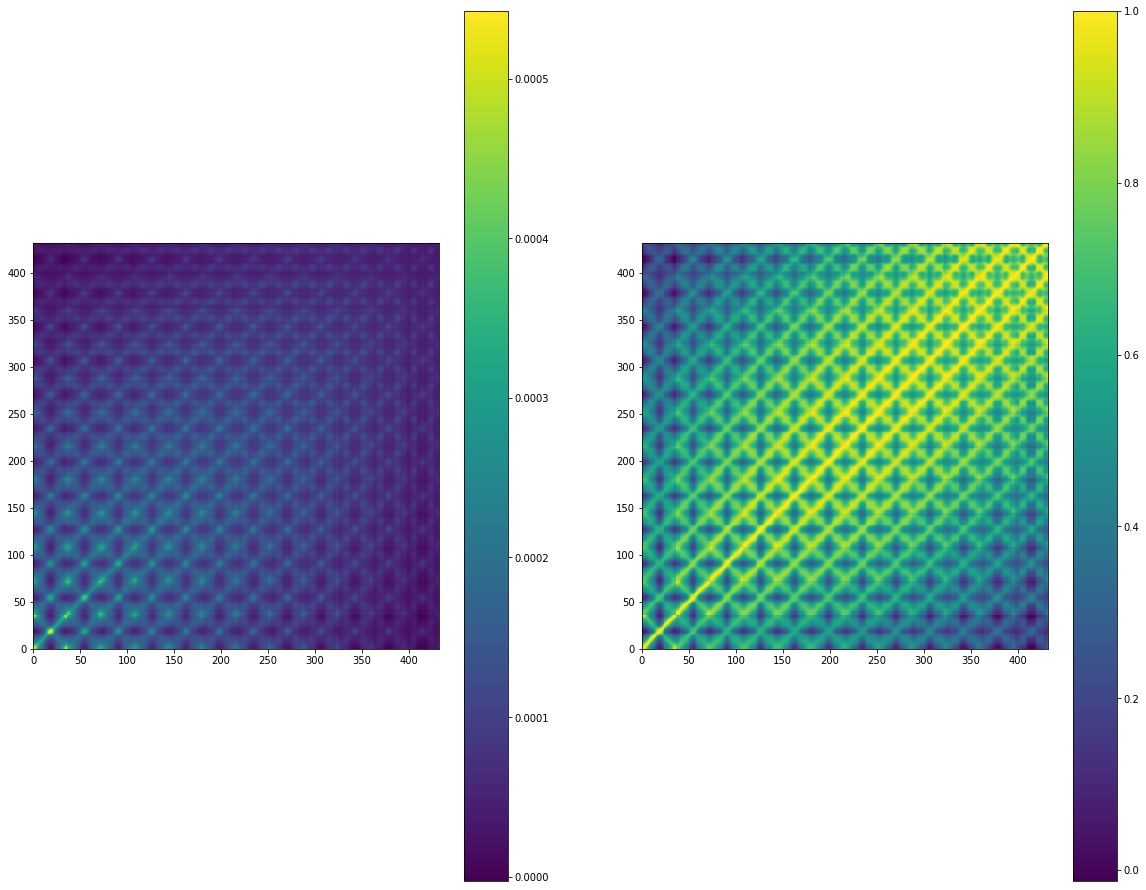

In [406]:
# visualizing covariance among features in the training set data - before and after z-scoring
# all features are nori*nsf = 432 total
import scipy
plt.figure(figsize=(20,16));

plt.subplot(1,2,1)

trn_features_actual = trn_features[:,0:n_features]
covariance_trn = np.cov(np.transpose(trn_features_actual))
plt.pcolormesh(covariance_trn)
plt.colorbar()
plt.axis('square')

plt.subplot(1,2,2)

trn_features_actual = scipy.stats.zscore(trn_features[:,0:n_features],axis=0)
covariance_trn = np.cov(np.transpose(trn_features_actual))
plt.pcolormesh(covariance_trn)
plt.colorbar()
plt.axis('square')

# plt.xticks(np.arange(0,35,9),labels=np.arange(0,179,45))
# plt.yticks(np.arange(0,35,9),labels=np.arange(0,179,45))

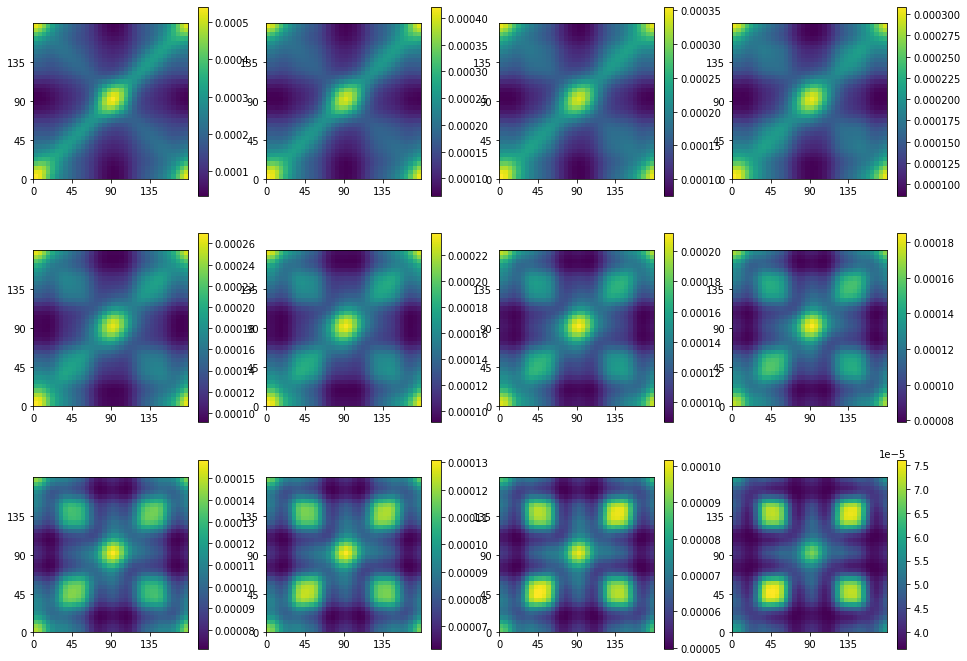

In [407]:
# visualizing just one SF at a time...

# trn_features_actual = scipy.stats.zscore(trn_features[:,0:n_features])
trn_features_actual = trn_features[:,0:n_features]
plt.figure(figsize=(16,16));
# plotting one sf at a time to see within-sf orientation covariance...
for sf2plot in range(n_sf):

    covariance_trn = np.cov(np.transpose(trn_features_actual[:,sf_tuning_masks[sf2plot]]))
    plt.subplot(4,4,sf2plot+1)
    plt.pcolormesh(covariance_trn)
    plt.colorbar()
    plt.axis('square')
    plt.xticks(np.arange(0,35,9),labels=np.arange(0,179,45))
    plt.yticks(np.arange(0,35,9),labels=np.arange(0,179,45))

(0.0, 13.0, 0.0, 13.0)

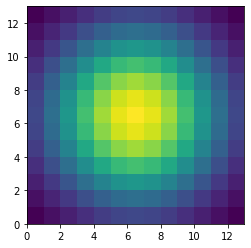

In [394]:
this_prf = pnu.make_gaussian_mass(x, y, sigma, n_pix, size=aperture, dtype=dtype)[2]
plt.figure();
plt.pcolormesh(this_prf)
plt.axis('square')

In [395]:
sf2plot = 9
ori1 = 9
ori2 = ori1+18
ori3 = ori1+9

feature1 = np.where(sf_tuning_masks[sf2plot])[0][ori1]
feature2 = np.where(sf_tuning_masks[sf2plot])[0][ori2]
feature3 = np.where(sf_tuning_masks[sf2plot])[0][ori3]
print(_gaborizer.feature_table.loc[feature1]['orientation']/np.pi*180)
print(orients_deg[ori1])
print(_gaborizer.feature_table.loc[feature1]['cycles per stimulus'])
print(cyc_per_stim[sf2plot])

45.0
45.0
40.40033721923828
40.400337


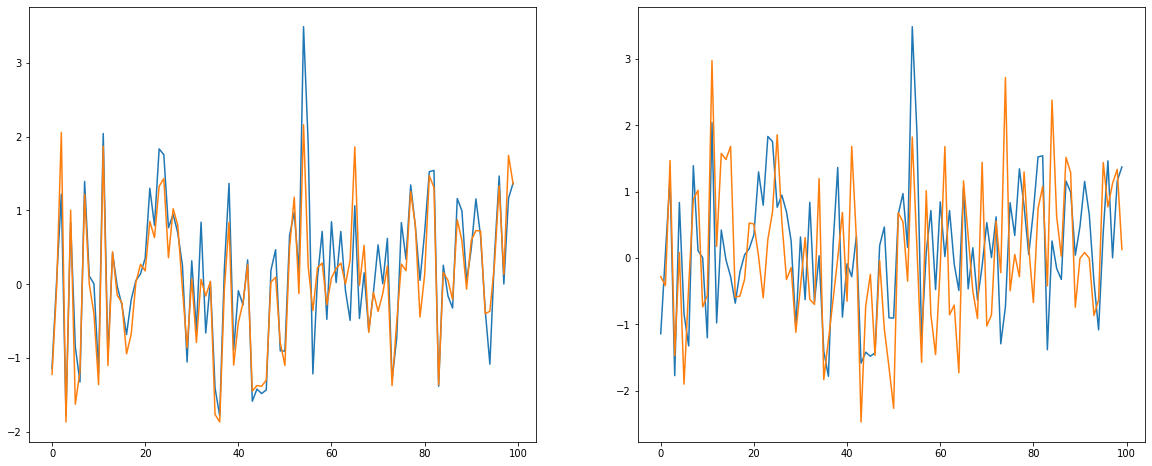

In [396]:
# trn_features_actual = scipy.stats.zscore(trn_features[:,0:n_features])
trn_features_actual = trn_features[:,0:n_features]
ims2plot = range(0,100)
plt.figure(figsize=(20,8));
plt.subplot(1,2,1)
plt.plot(trn_features_actual[ims2plot,feature1])
plt.plot(trn_features_actual[ims2plot,feature2])

plt.subplot(1,2,2)
plt.plot(trn_features_actual[ims2plot,feature1])
plt.plot(trn_features_actual[ims2plot,feature3])

In [433]:
# Using weights to assess orient/SF tuning separately
feature_weights = best_params[1]

allw_reshaped = np.reshape(feature_weights, [n_voxels, n_ori, n_sf], order='F')

mean_orient_weights = np.mean(allw_reshaped, axis=2)
print(np.shape(mean_orient_weights))
mean_sf_weights = np.mean(allw_reshaped, axis=1)
print(np.shape(mean_sf_weights))

max_orient_weight_ind = np.argmax(mean_orient_weights, axis=1)
preferred_ori_weights = orients_deg[max_orient_weight_ind]

max_sf_weight_ind = np.argmax(mean_sf_weights, axis=1)
preferred_sf_weights = cyc_per_stim[max_sf_weight_ind]

(1, 36)
(1, 12)


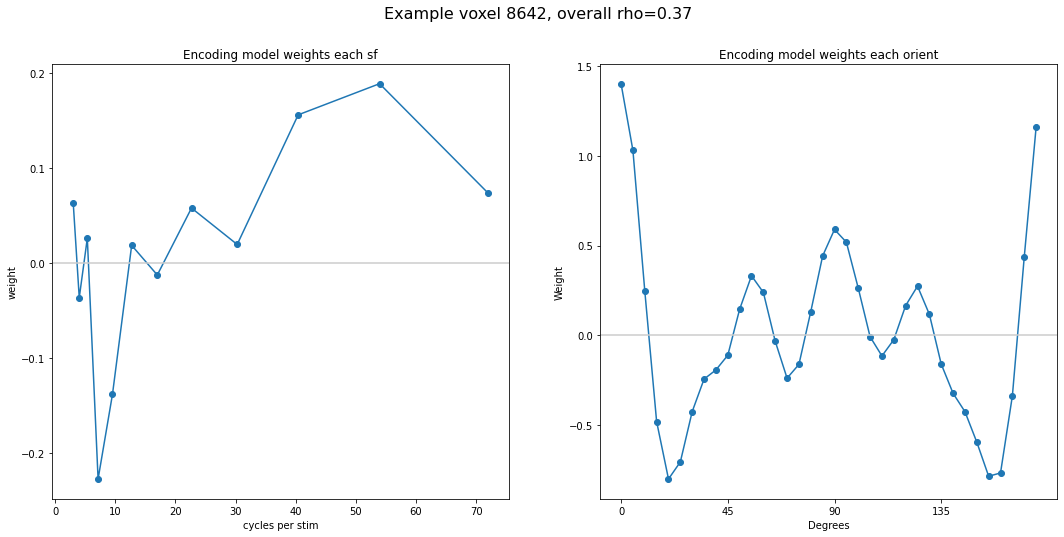

In [436]:
# Plotting tuning for one example voxel

plt.figure(figsize=(18,8))

plt.subplot(1,2,1)
plt.plot(cyc_per_stim, mean_sf_weights[0,:],'-o')
plt.xlabel('cycles per stim')
plt.ylabel('weight')
plt.title('Encoding model weights each sf')
plt.axhline(0, color=[0.8, 0.8, 0.8])


plt.subplot(1,2,2)
# plt.plot(orients_deg, allw_reshaped[vidx,4,:])
plt.plot(orients_deg, mean_orient_weights[0,:],'-o')
plt.xlabel('Degrees')
plt.ylabel('Weight')
plt.title('Encoding model weights each orient')
plt.axhline(0, color=[0.8, 0.8, 0.8])
plt.xticks(np.arange(0,179,45))

plt.suptitle('Example voxel %d, overall rho=%.2f'%(vidx, val_cc[0]),fontsize=16);

In [417]:
max_ori_ind

array([20, 16, 21, ...,  0, 20,  2])

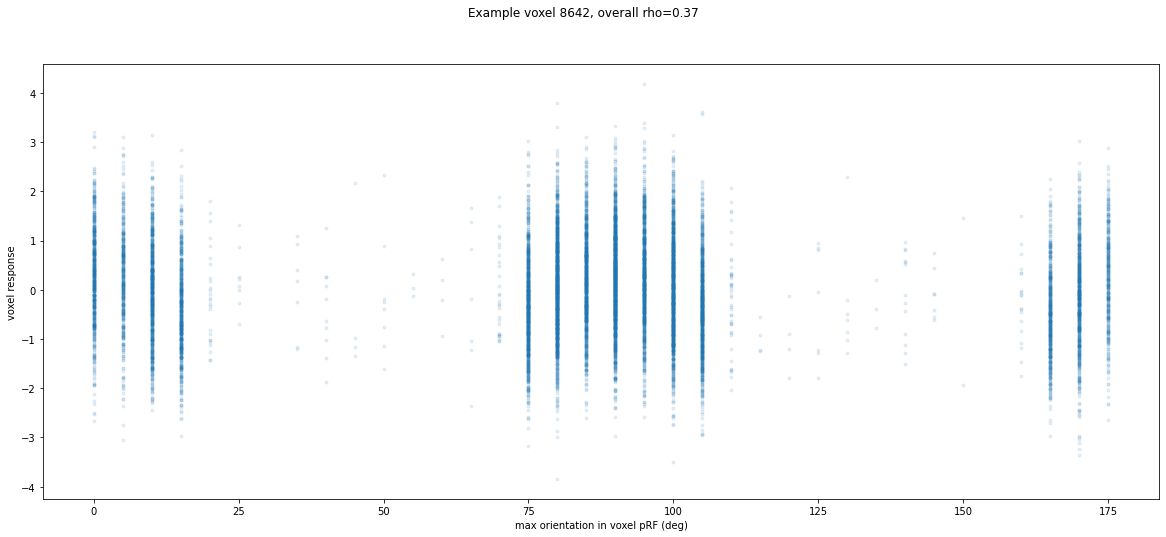

In [440]:
dat2plot = trn_data
sf2plot = 10
# taking out just orientations at the SF which had highest weight
# features2use = actinprf[:,sf_tuning_masks[best_sf]]
trn_features_actual = trn_features[:,0:n_features]
# trn_features_actual = scipy.stats.zscore(trn_features[:,0:n_features], axis=0)
features2use = trn_features_actual[:,sf_tuning_masks[sf2plot]]

max_ori_ind = np.argmax(features2use,axis=1)

plt.figure(figsize=(20,8));
plt.plot(orients_deg[max_ori_ind], trn_data,'.',alpha=0.1)
plt.xlabel('max orientation in voxel pRF (deg)')
plt.ylabel('voxel response')

plt.suptitle('Example voxel %d, overall rho=%.2f'%(vidx, val_cc[0]));

[ 0.12351343  0.1188475   0.10498204  0.08306261  0.05795102  0.03470064
  0.01589869  0.00376008 -0.00045777  0.00191824  0.00999563  0.02440593
  0.04674717  0.07445001  0.10292638  0.12930862  0.15015649  0.16243026
  0.16654827  0.16364001  0.15231891  0.13179658  0.10488757  0.07526481
  0.04651888  0.02386557  0.00936763  0.00131256 -0.00068371  0.00388677
  0.01652171  0.03598336  0.05975329  0.08494758  0.10655464  0.11970083]


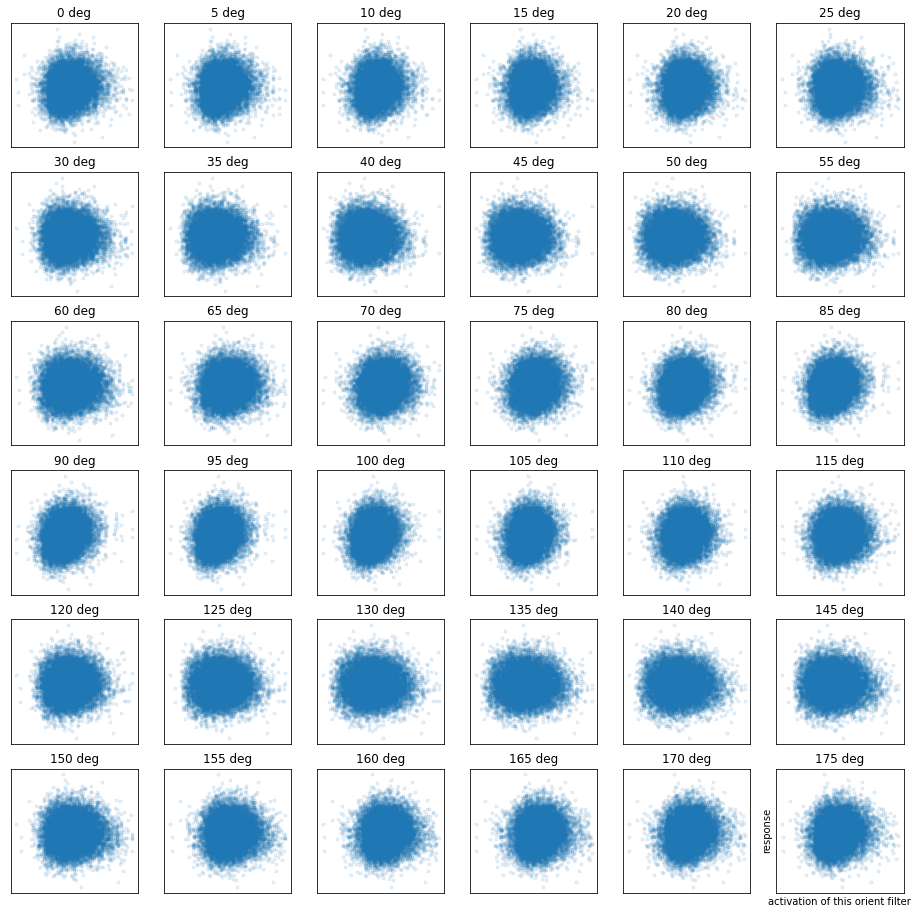

In [441]:
# Now want to measure how the voxel responded to trials with a given orientation content.
# for each orient channel, going to plot voxel's response versus activation in that channel.

dat2plot = trn_data

sf2plot = 10
# taking out just orientations at the SF which had highest weight
# features2use = actinprf[:,sf_tuning_masks[best_sf]]
trn_features_actual = trn_features[:,0:n_features]
# trn_features_actual = scipy.stats.zscore(trn_features[:,0:n_features], axis=0)
features2use = trn_features_actual[:,sf_tuning_masks[sf2plot]]

# np.shape(features2use)
# estimating the "best" orientation for each trial
# max_ori_each_trial = orients_deg[np.argmax(features2use,axis=1)]

resp_corrs = np.zeros((n_ori,))
plt.figure(figsize=(16,16));
for oo in range(n_ori):
    plt.subplot(6,6,oo+1)
    plt.plot(features2use[:,oo], dat2plot,'.',alpha=0.1)
    resp_corrs[oo] = np.corrcoef(features2use[:,oo], dat2plot[:,0])[0,1]
    plt.title('%d deg'%np.round(orients_deg[oo],1))
    plt.xticks([]); plt.yticks([])
    if oo==n_ori-1:
        plt.xlabel('activation of this orient filter')
        plt.ylabel('response')
        
print(resp_corrs)

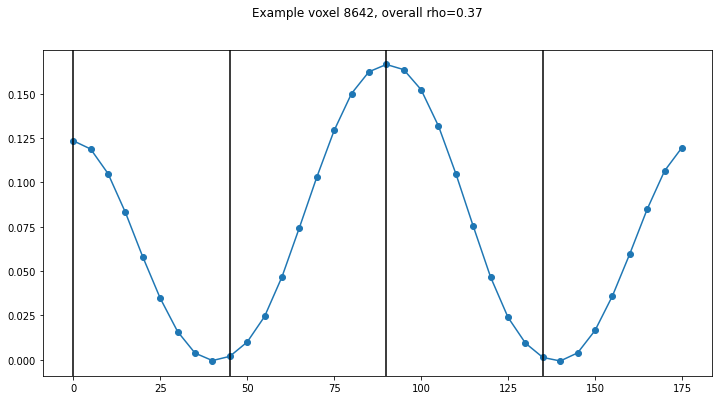

In [442]:
# Correlation coefficient between filter activation and voxel response, as a function of filter orientation

plt.figure(figsize=(12,6));
plt.plot(orients_deg, resp_corrs,'-o')
for oo in np.arange(0,179,45):
    plt.axvline(oo,color='k')
plt.suptitle('Example voxel %d, overall rho=%.2f'%(vidx, val_cc[0]));

In [443]:

def learn_params_ridge_regression(images, voxel_data, _fmaps_fn, models, lambdas, aperture=1.0, zscore=False, sample_batch_size=100, voxel_batch_size=100, holdout_size=100, shuffle=True, add_bias=False, debug=False):
    """
    Learn the parameters of the fwRF model

    Parameters
    ----------
    images : ndarray, shape (#samples, #channels, x, y)
        Input image block.
    voxels: ndarray, shape (#samples, #voxels)
        Input voxel activities.
    _fmaps_fn: Torch module
        Torch module that returns a list of torch tensors.
        This is defined previously, maps from images to list feature maps.
    models: ndarray, shape (#candidateRF, 3)
        The (x, y, sigma) of all candidate RFs for gridsearch.
    lambdas: ndarray, shape (#candidateRegression)
        The rigde parameter candidates.
    aperture (default: 1.0): scalar
        The span of the stimulus in the unit used for the RF models.
    zscore (default: False)
        Whether to zscore the feature maps or not.
    sample_batch_size (default: 100)
        The sample batch size (used where appropriate)
    voxel_batch_size (default: 100) 
        The voxel batch size (used where appropriate)
    holdout_size (default: 100) 
        The holdout size for model and hyperparameter selection
    shuffle (default: True)
        Whether to shuffle the training set or not.
    add_bias (default: False)
        Whether to add a bias term to the rigde regression or not.

    Returns
    -------
    losses : ndarray, shape (#voxels)
        The final loss for each voxel.
    lambdas : ndarray, shape (#voxels)
        The regression regularization index for each voxel.
    models : ndarray, shape (#voxels, 3)
        The RF model (x, y, sigma) associated with each voxel.
    params : list of ndarray, shape (#voxels, #features)
        Can contain a bias parameter of shape (#voxels) if add_bias is True.
    features_mean : ndarray, shape (#voxels, #feature)
        None if zscore is False. Otherwise returns zscoring average per feature.
    features_std : ndarray, shape (#voxels, #feature)
        None if zscore is False. Otherwise returns zscoring std.dev. per feature.
    """

    dtype = images.dtype.type
    device = next(_fmaps_fn.parameters()).device
    trn_size = len(voxel_data) - holdout_size
    assert trn_size>0, 'Training size needs to be greater than zero'
    
    print ('trn_size = %d (%.1f%%)' % (trn_size, float(trn_size)*100/len(voxel_data)))
    print ('dtype = %s' % dtype)
    print ('device = %s' % device)
    print ('---------------------------------------')
    
    # First do shuffling of data and define set to hold out
    n_trials = len(images)
    n_prfs = len(models)
    n_voxels = voxel_data.shape[1]
    order = np.arange(len(voxel_data), dtype=int)
    if shuffle:
        np.random.shuffle(order)
    images = images[order]
    voxel_data = voxel_data[order]  
    trn_data = voxel_data[:trn_size]
    out_data = voxel_data[trn_size:]
    
    # Looping over the feature maps once with a batch of images, to get their sizes
    n_features, fmaps_rez = get_fmaps_sizes(_fmaps_fn, images[0:sample_batch_size], device)
    
    # Create full model value buffers    
    best_models = np.full(shape=(n_voxels,), fill_value=-1, dtype=int)   
    best_lambdas = np.full(shape=(n_voxels,), fill_value=-1, dtype=int)
    best_losses = np.full(fill_value=np.inf, shape=(n_voxels), dtype=dtype)
    best_w_params = np.zeros(shape=(n_voxels, n_features ), dtype=dtype)

    if add_bias:
        best_w_params = np.concatenate([best_w_params, np.ones(shape=(len(best_w_params),1), dtype=dtype)], axis=1)
    features_mean = None
    features_std = None
    if zscore:
        features_mean = np.zeros(shape=(n_voxels, n_features), dtype=dtype)
        features_std  = np.zeros(shape=(n_voxels, n_features), dtype=dtype)
    
    # going to save the covariance matrices too, see how correlated features are in training data.
    covar_each_model = np.zeros(shape=(n_features, n_features, n_prfs), dtype=dtype)
    
    start_time = time.time()
    vox_loop_time = 0
    print ('')
    
    with torch.no_grad():
        
        # Looping over models (here models are different spatial RF definitions)
        for m,(x,y,sigma) in enumerate(models):
            if debug and m>1:
                break

            t = time.time()            
            # Get features for the desired pRF, across all trn set image            
            features = get_features_in_prf((x,y,sigma), _fmaps_fn, images, sample_batch_size, device)     
            elapsed = time.time() - t
        
            if zscore:  
                features_m = np.mean(features, axis=0, keepdims=True) #[:trn_size]
                features_s = np.std(features, axis=0, keepdims=True) + 1e-6          
                features -= features_m
                features /= features_s    
                
            if add_bias:
                features = np.concatenate([features, np.ones(shape=(len(features), 1), dtype=dtype)], axis=1)
            
            # separate design matrix into training/held out data (for lambda selection)
            trn_features = features[:trn_size]
            out_features = features[trn_size:]   

            # Calculate covariance, just to look at later
            covar_each_model[:,:,m] = np.cov(np.transpose(trn_features))            
            
            # Send matrices to gpu
            _xtrn = _to_torch(trn_features, device=device)
            _xout = _to_torch(out_features, device=device)   
            
            # Do part of the matrix math involved in ridge regression optimization out of the loop, 
            # because this part will be same for all the voxels.
            _cof = _cofactor_fn(_xtrn, lambdas, device=device)
            
            # Now looping over batches of voxels (only reason is because can't store all in memory at same time)
            vox_start = time.time()
            for rv,lv in iterate_range(0, n_voxels, voxel_batch_size):
                sys.stdout.write('\rfitting model %4d of %-4d, voxels [%6d:%-6d] of %d' % (m, n_prfs, rv[0], rv[-1], n_voxels))

                # Send matrices to gpu
                _vtrn = _to_torch(trn_data[:,rv], device=device)
                _vout = _to_torch(out_data[:,rv], device=device)

                # Here is where optimization happens - relatively simple matrix math inside loss fn.
                _betas, _loss = _loss_fn(_cof, _vtrn, _xout, _vout) #   [#lambda, #feature, #voxel, ], [#lambda, #voxel]
                # Now have a set of weights (in betas) and a loss value for every voxel and every lambda. 
                # goal is then to choose for each voxel, what is the best lambda and what weights went with that lambda.

                # first choose best lambda value and the loss that went with it.
                _values, _select = torch.min(_loss, dim=0)
                betas = get_value(_betas)
                values, select = get_value(_values), get_value(_select)

                # comparing this loss to the other models for each voxel (e.g. the other RF position/sizes)
                imp = values<best_losses[rv]

                if np.sum(imp)>0:
                    # for whichever voxels had improvement relative to previous models, save parameters now
                    # this means we won't have to save all params for all models, just best.
                    arv = np.array(rv)[imp]
                    li = select[imp]
                    best_lambdas[arv] = li
                    best_losses[arv] = values[imp]
                    best_models[arv] = m
                    if zscore:
                        features_mean[arv] = features_m # broadcast over updated voxels
                        features_std[arv]  = features_s
                    # taking the weights associated with the best lambda value
                    best_w_params[arv,:] = pnu.select_along_axis(betas[:,:,imp], li, run_axis=2, choice_axis=0).T
                    
            vox_loop_time += (time.time() - vox_start)
            elapsed = (time.time() - vox_start)

    # Print information about how fitting went...
    total_time = time.time() - start_time
    inv_time = total_time - vox_loop_time
    return_params = [best_w_params[:,:n_features],]
    if add_bias:
        return_params += [best_w_params[:,-1],]
    else: 
        return_params += [None,]
    print ('\n---------------------------------------')
    print ('total time = %fs' % total_time)
    print ('total throughput = %fs/voxel' % (total_time / n_voxels))
    print ('voxel throughput = %fs/voxel' % (vox_loop_time / n_voxels))
    print ('setup throughput = %fs/model' % (inv_time / n_prfs))
    sys.stdout.flush()
    return best_losses, best_lambdas, [models[best_models],]+return_params+[features_mean, features_std], covar_each_model


In [222]:
from src.numpy_utility import iterate_range


def get_predictions(images, _fmaps_fn, _fwrf_fn, params, sample_batch_size=100):
    """
    The predictive fwRF model for arbitrary input image.

    Parameters
    ----------
    images : ndarray, shape (#samples, #channels, x, y)
        Input image block.
    _fmaps_fn: Torch module
        Torch module that returns a list of torch tensors.
        This is defined previously, maps from images to feature maps.
    _fwrf_fn: Torch module
        Torch module that compute the fwrf model for one batch of voxels
        Defined in Torch_fwrf_voxel_block
    params: list including all of the following:
    [
        models : ndarray, shape (#voxels, 3)
            The RF model (x, y, sigma) associated with each voxel.
        weights : ndarray, shape (#voxels, #features)
            Tuning weights
        bias: Can contain a bias parameter of shape (#voxels) if add_bias is True.
           Tuning biases: None if there are no bias
        features_mean (optional): ndarray, shape (#voxels, #feature)
            None if zscore is False. Otherwise returns zscoring average per feature.
        features_std (optional): ndarray, shape (#voxels, #feature)
            None if zscore is False. Otherwise returns zscoring std.dev. per feature.
    ]
    sample_batch_size (default: 100)
        The sample batch size (used where appropriate)

    Returns
    -------
    pred : ndarray, shape (#samples, #voxels)
        The prediction of voxel activities for each voxels associated with the input images.
    """
    
    dtype = images.dtype.type
    device = next(_fmaps_fn.parameters()).device
    _params = [_p for _p in _fwrf_fn.parameters()]
    voxel_batch_size = _params[0].size()[0]    
    n_trials, n_voxels = len(images), len(params[0])
    #print ('val_size = %d' % nt)
    pred = np.full(fill_value=0, shape=(n_trials, n_voxels), dtype=dtype)
    start_time = time.time()
    
    with torch.no_grad():
        
        ## Looping over voxels here in batches, will eventually go through all.
        for rv, lv in iterate_range(0, n_voxels, voxel_batch_size):
            
            # for this voxel batch, put the right parameters into the _fwrf_fn module
            # so that we can do forward pass...
            _fwrf_fn.load_voxel_block(*[p[rv] if p is not None else None for p in params])
            pred_block = np.full(fill_value=0, shape=(n_trials, voxel_batch_size), dtype=dtype)
            
            # Now looping over validation set trials in batches
            for rt, lt in iterate_range(0, n_trials, sample_batch_size):
                sys.stdout.write('\rsamples [%5d:%-5d] of %d, voxels [%6d:%-6d] of %d' % (rt[0], rt[-1], n_trials, rv[0], rv[-1], n_voxels))
                # Get predictions for this set of trials.
#                 print('shape of full matrix')
#                 print(pred_block.shape)
#                 print('shape of new element')
#                 print(np.shape(get_value(_fwrf_fn(_fmaps_fn(_to_torch(images[rt], device))))))
                pred_block[rt] = get_value(_fwrf_fn(_fmaps_fn(_to_torch(images[rt], device)))) 
                
            pred[:,rv] = pred_block[:,:lv]
            
    total_time = time.time() - start_time
    print ('\n---------------------------------------')
    print ('total time = %fs' % total_time)
    print ('sample throughput = %fs/sample' % (total_time / n_trials))
    print ('voxel throughput = %fs/voxel' % (total_time / n_voxels))
    sys.stdout.flush()
    return pred



In [223]:
import torch.nn as nn
class Torch_fwRF_voxel_block(nn.Module):
    '''
    This is the module that maps from feature maps to voxel predictions according to weights.
    This works for a batch of voxels at a time. 
    Initialize with one set of voxels, but can use load_voxel_block to run w different batches
    '''

    def __init__(self, _fmaps_fn, params, input_shape=(1,3,227,227), aperture=1.0):
        super(Torch_fwRF_voxel_block, self).__init__()
        print('Making fwrf module...')
        self.aperture = aperture
        models, weights, bias, features_mt, features_st = params
        device = next(_fmaps_fn.parameters()).device
        _x =torch.empty((1,)+input_shape[1:], device=device).uniform_(0, 1)
        _fmaps = _fmaps_fn(_x)
        self.fmaps_rez = []
        for k,_fm in enumerate(_fmaps):
            assert _fm.size()[2]==_fm.size()[3], 'All feature maps need to be square'
            self.fmaps_rez += [_fm.size()[2],]
        
        self.prfs = []
        for k,n_pix in enumerate(self.fmaps_rez):
            prf = pnu.make_gaussian_mass_stack(models[:,0], models[:,1], models[:,2], n_pix, size=aperture, dtype=np.float32)[2]
            self.prfs += [nn.Parameter(torch.from_numpy(prf).to(device), requires_grad=False),]
            self.register_parameter('prfs%d'%k, self.prfs[-1])
            
        self.weights = nn.Parameter(torch.from_numpy(weights).to(device), requires_grad=False)
        self.bias = None
        if bias is not None:
            self.bias = nn.Parameter(torch.from_numpy(bias).to(device), requires_grad=False)
            
        self.features_m = None
        self.features_s = None
        if features_mt is not None:
            self.features_m = nn.Parameter(torch.from_numpy(features_mt.T).to(device), requires_grad=False)
        if features_st is not None:
            self.features_s = nn.Parameter(torch.from_numpy(features_st.T).to(device), requires_grad=False)
            
    def load_voxel_block(self, *params):
        # This takes a given set of parameters for the voxel batch of interest, and puts them 
        # into the right fields of the module so we can use them in a forward pass.
        models = params[0]
        for _prfs,n_pix in zip(self.prfs, self.fmaps_rez):
            prfs = pnu.make_gaussian_mass_stack(models[:,0], models[:,1], models[:,2], n_pix, size=self.aperture, dtype=np.float32)[2]
            if len(prfs)<_prfs.size()[0]:
                pp = np.zeros(shape=_prfs.size(), dtype=prfs.dtype)
                pp[:len(prfs)] = prfs
                set_value(_prfs, pp)
            else:
                set_value(_prfs, prfs)
        for _p,p in zip([self.weights, self.bias], params[1:3]):
            if _p is not None:
                if len(p)<_p.size()[0]:
                    pp = np.zeros(shape=_p.size(), dtype=p.dtype)
                    pp[:len(p)] = p
                    set_value(_p, pp)
                else:
                    set_value(_p, p)
        for _p,p in zip([self.features_m, self.features_s], params[3:]):
            if _p is not None:
                if len(p)<_p.size()[1]:
                    pp = np.zeros(shape=(_p.size()[1], _p.size()[0]), dtype=p.dtype)
                    pp[:len(p)] = p
                    set_value(_p, pp.T)
                else:
                    set_value(_p, p.T)
 
    def forward(self, _fmaps):
        _features = torch.cat([torch.tensordot(_fm, _prf, dims=[[2,3], [1,2]]) for _fm,_prf in zip(_fmaps, self.prfs)], dim=1) # [#samples, #features, #voxels] 
        if self._nl is not None:
            _features = self._nl(_features)
        if self.features_m is not None:              
            _features -= self.features_m[None]
        if self.features_s is not None:
            _features /= self.features_s[None]
        _features = torch.transpose(torch.transpose(_features, 0, 2), 1, 2) # [#voxels, #samples, features]
        _r = torch.squeeze(torch.bmm(_features, torch.unsqueeze(self.weights, 2))).t() # [#samples, #voxels]
        if self.bias is not None:
#             print(_r.shape)
#             print(self.bias.shape)
            _r += self.bias
            _r = torch.unsqueeze(_r, 1)
#             _r += torch.unsqueeze(self.bias, 0)
        
        return _r


    

In [220]:
def get_r2(actual,predicted):
  
    # calculate r2 for this fit.
    ssres = np.sum(np.power((predicted - actual),2));
#     print(ssres)
    sstot = np.sum(np.power((actual - np.mean(actual)),2));
#     print(sstot)
    r2 = 1-(ssres/sstot)
    
    return r2

NameError: name '_r' is not defined

In [161]:
models = best_params[0][np.newaxis,:]
models.shape
n_pix = fmaps_rez[0]

In [162]:
prf = pnu.make_gaussian_mass_stack(models[:,0], models[:,1], models[:,2], n_pix, size=aperture, dtype=np.float32)[2]

In [163]:
np.shape(prf)

(1, 13, 13)

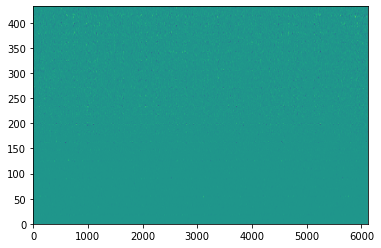

In [78]:

plt.figure();
plt.pcolormesh(_cof[0,:,:].cpu().numpy())

In [102]:
# Create full model value buffers   

best_models = np.full(shape=(n_voxels,), fill_value=-1, dtype=int)   
best_lambdas = np.full(shape=(n_voxels,), fill_value=-1, dtype=int)
best_losses = np.full(shape=(n_voxels), fill_value=np.inf, dtype=dtype)
best_w_params = np.zeros(shape=(n_voxels, n_features ), dtype=dtype)

if add_bias:
    best_w_params = np.concatenate([best_w_params, np.ones(shape=(len(best_w_params),1), dtype=dtype)], axis=1)
features_mean = None
features_std = None

if zscore:
    features_mean = np.zeros(shape=(n_voxels, n_features), dtype=dtype)
    features_std  = np.zeros(shape=(n_voxels, n_features), dtype=dtype)


In [63]:
# Now looping over batches of voxels (only reason is because can't store all in memory at same time)
vox_start = time.time()
for rv,lv in iterate_range(0, n_voxels, voxel_batch_size):
    sys.stdout.write('\rfitting model %4d of %-4d, voxels [%6d:%-6d] of %d' % (m, n_prfs, rv[0], rv[-1], n_voxels))

    # Send matrices to gpu
    _vtrn = _to_torch(trn_data[:,rv], device=device)
    _vout = _to_torch(out_data[:,rv], device=device)

    # Here is where optimization happens - relatively simple matrix math inside loss fn.
    _betas, _loss = _loss_fn(_cof, _vtrn, _xout, _vout) #   [#lambda, #feature, #voxel, ], [#lambda, #voxel]
    # Now have a set of weights (in betas) and a loss value for every voxel and every lambda. 
    # goal is then to choose for each voxel, what is the best lambda and what weights went with that lambda.

    # first choose best lambda value and the loss that went with it.
    _values, _select = torch.min(_loss, dim=0)
    betas = get_value(_betas)
    values, select = get_value(_values), get_value(_select)

    # comparing this loss to the other models for each voxel (e.g. the other RF position/sizes)
    imp = values<best_losses[rv]

    if np.sum(imp)>0:
        # for whichever voxels had improvement relative to previous models, save parameters now
        # this means we won't have to save all params for all models, just best.
        arv = np.array(rv)[imp]
        li = select[imp]
        best_lambdas[arv] = li
        best_losses[arv] = values[imp]
        best_models[arv] = m
        if zscore:
            features_mean[arv] = features_m # broadcast over updated voxels
            features_std[arv]  = features_s
        # taking the weights associated with the best lambda value
        best_w_params[arv,:] = pnu.select_along_axis(betas[:,:,imp], li, run_axis=2, choice_axis=0).T

vox_loop_time += (time.time() - vox_start)
elapsed = (time.time() - vox_start)

array([[0.0109251 , 0.01096813, 0.01085213, 0.01053616, 0.01016662,
        0.00991452, 0.00982426, 0.009789  , 0.00975467, 0.00975343,
        0.00977824, 0.00987075, 0.01004786, 0.01033693, 0.01087241,
        0.01175082, 0.01271789, 0.0134658 , 0.01374188, 0.01345967,
        0.01270146, 0.01171048, 0.01083356, 0.01030403, 0.01000768,
        0.00982419, 0.00975316, 0.00974213, 0.00977659, 0.00981259,
        0.00983306, 0.00993344, 0.01018283, 0.01054902, 0.01085807,
        0.01096866, 0.01002119, 0.01012655, 0.0101623 , 0.01002031,
        0.00978146, 0.00953662, 0.00935498, 0.00924536, 0.00920501,
        0.00919116, 0.00922473, 0.00933331, 0.00951712, 0.00977097,
        0.01024659, 0.01098724, 0.01187241, 0.01258148, 0.01284557,
        0.01256956, 0.01184637, 0.01095329, 0.01020782, 0.00974351,
        0.00948742, 0.00932224, 0.00924078, 0.00922573, 0.00923104,
        0.00928697, 0.00939603, 0.00956883, 0.00980525, 0.01003698,
        0.01017096, 0.01012496, 0.00944782, 0.00